To run the following code, `pip install pandas, numpy, seaborn, missingno, matplotlib, skicit-learn`.
The expected outputs are as follow.

In [219]:
import pandas as pd
inventory = pd.read_csv("T_F41SCHEDULE_B43.zip")

C:\Users\siddh\AppData\Local\Temp\ipykernel_9264\1036293980.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  inventory = pd.read_csv("T_F41SCHEDULE_B43.zip")


In [220]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132313 non-null  int64  
 1   CARRIER              132264 non-null  object 
 2   CARRIER_NAME         132208 non-null  object 
 3   MANUFACTURE_YEAR     132310 non-null  float64
 4   UNIQUE_CARRIER_NAME  132208 non-null  object 
 5   SERIAL_NUMBER        132313 non-null  object 
 6   TAIL_NUMBER          132313 non-null  object 
 7   AIRCRAFT_STATUS      132313 non-null  object 
 8   OPERATING_STATUS     132313 non-null  object 
 9   NUMBER_OF_SEATS      132306 non-null  float64
 10  MANUFACTURER         132313 non-null  object 
 11  AIRCRAFT_TYPE        102380 non-null  object 
 12  MODEL                132302 non-null  object 
 13  CAPACITY_IN_POUNDS   132212 non-null  float64
 14  ACQUISITION_DATE     131346 non-null  object 
 15  AIRLINE_ID       

## Question 1 - missing value imputation

In [221]:
columns_to_check = [
    'CARRIER',
    'CARRIER_NAME',
    'MANUFACTURE_YEAR',
    'NUMBER_OF_SEATS',
    'CAPACITY_IN_POUNDS',
    'AIRLINE_ID'
]

imputed_inventory = inventory.copy()

<Axes: >

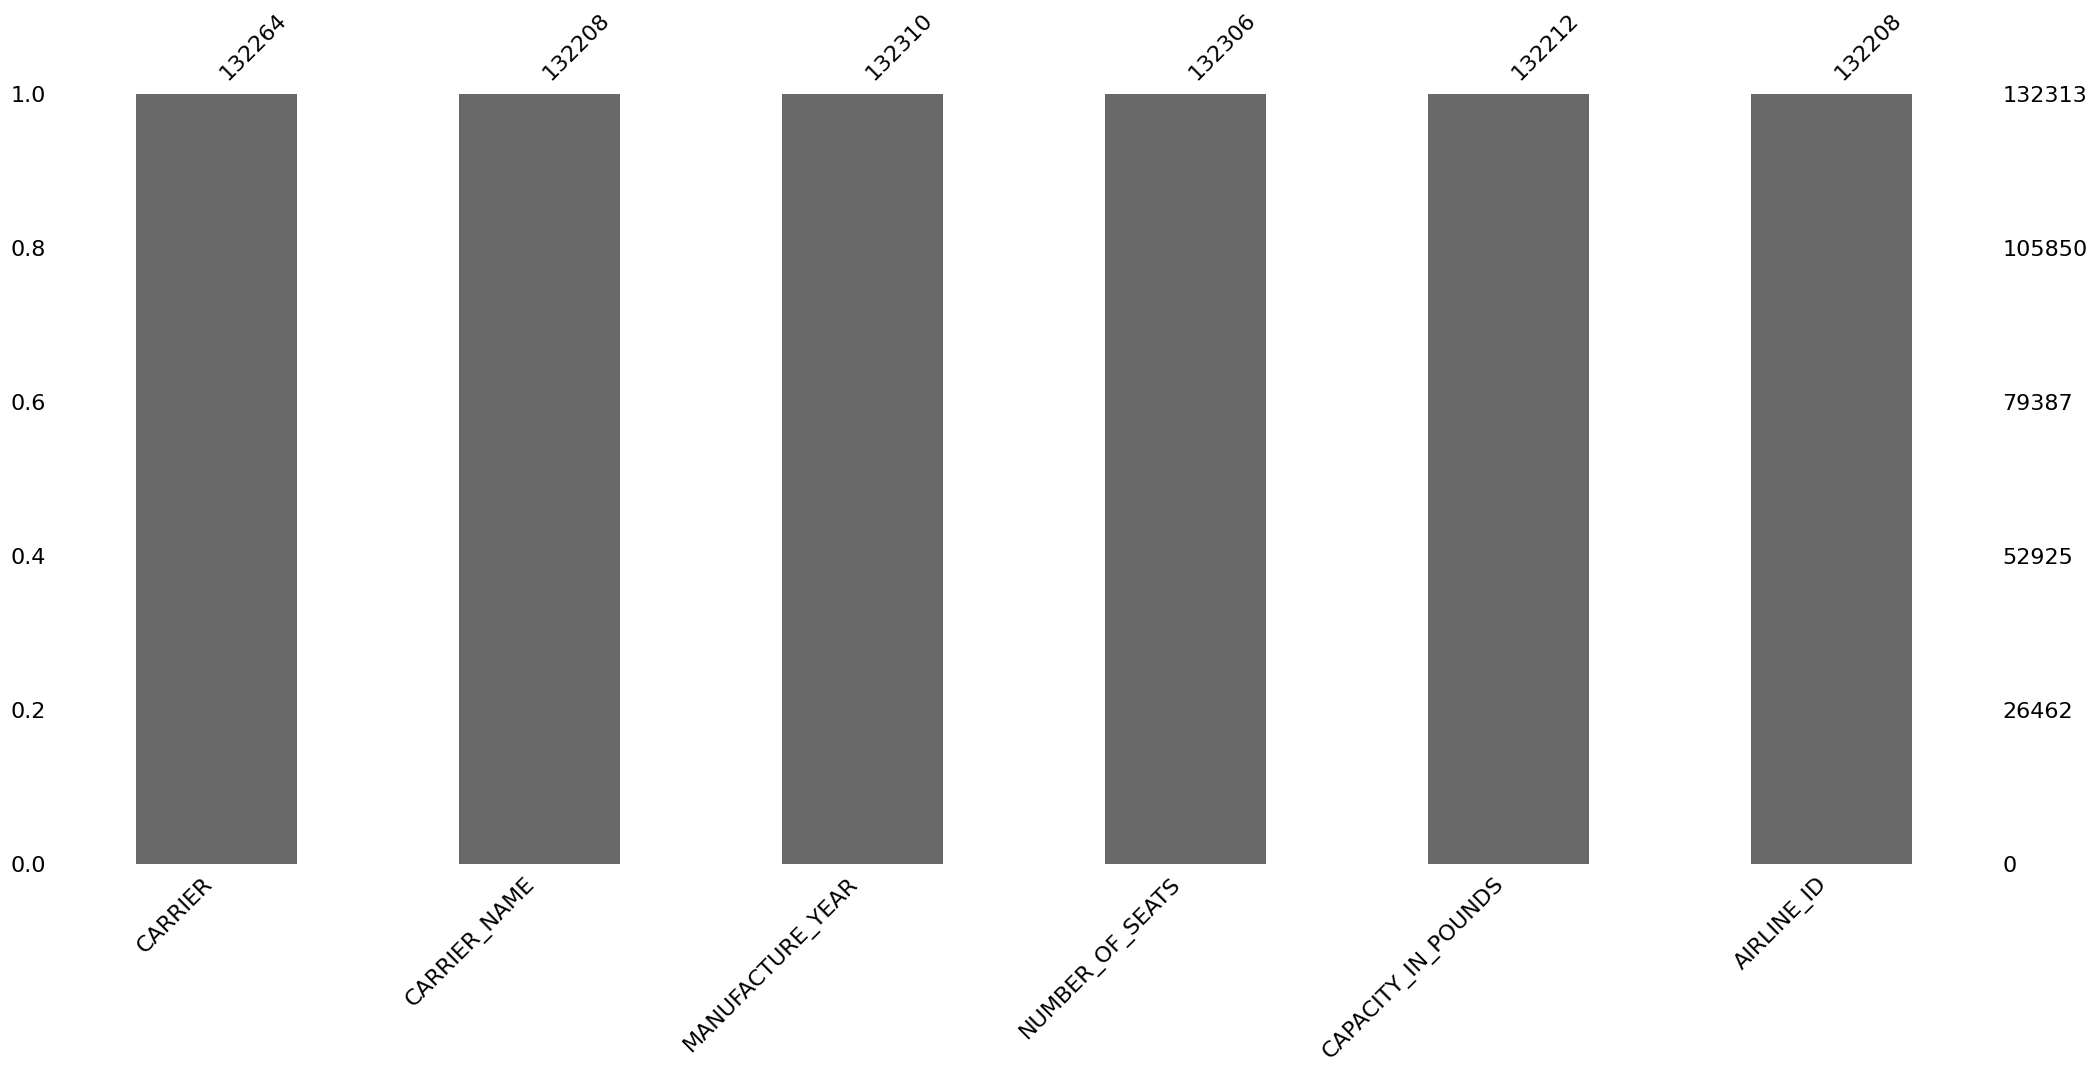

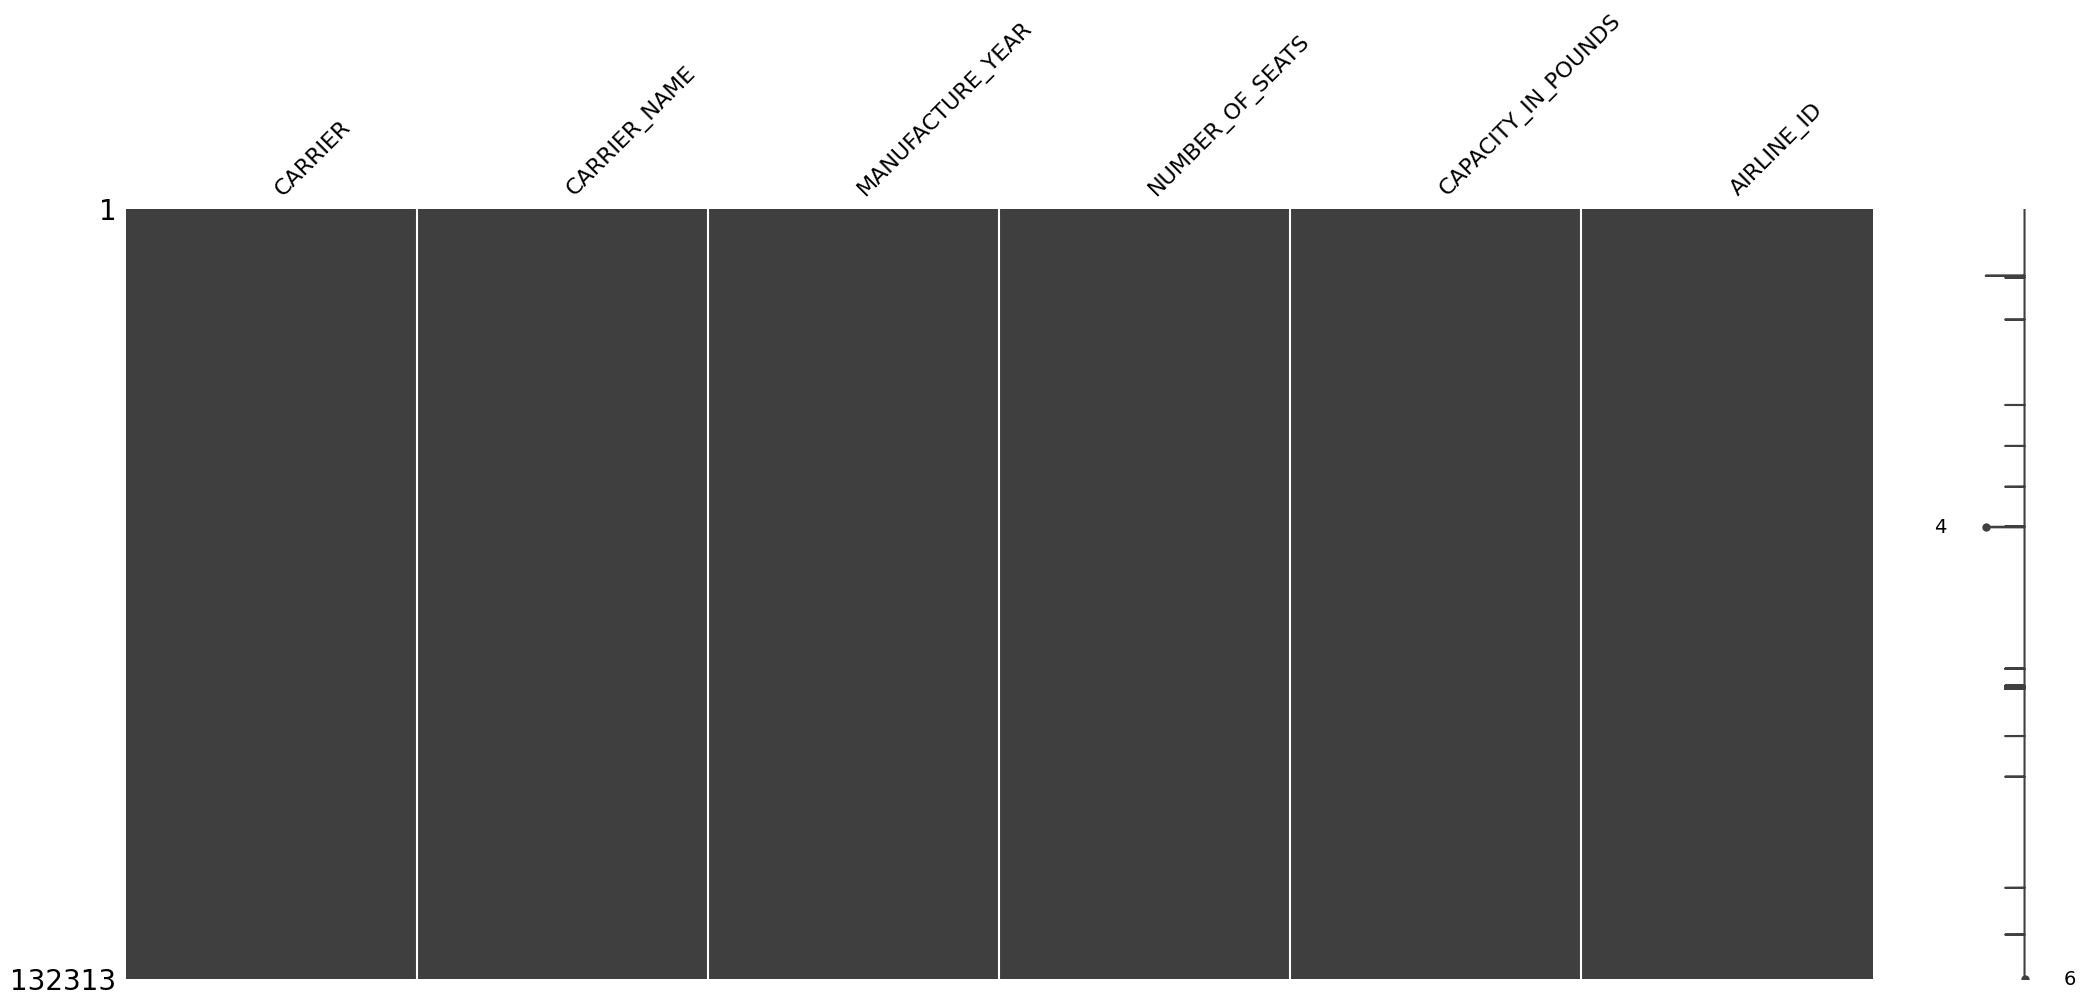

In [222]:
import missingno as msno

msno.bar(inventory[columns_to_check])
msno.matrix(inventory[columns_to_check])


# shows us really low percentage of missing and also no MNAR

<Axes: >

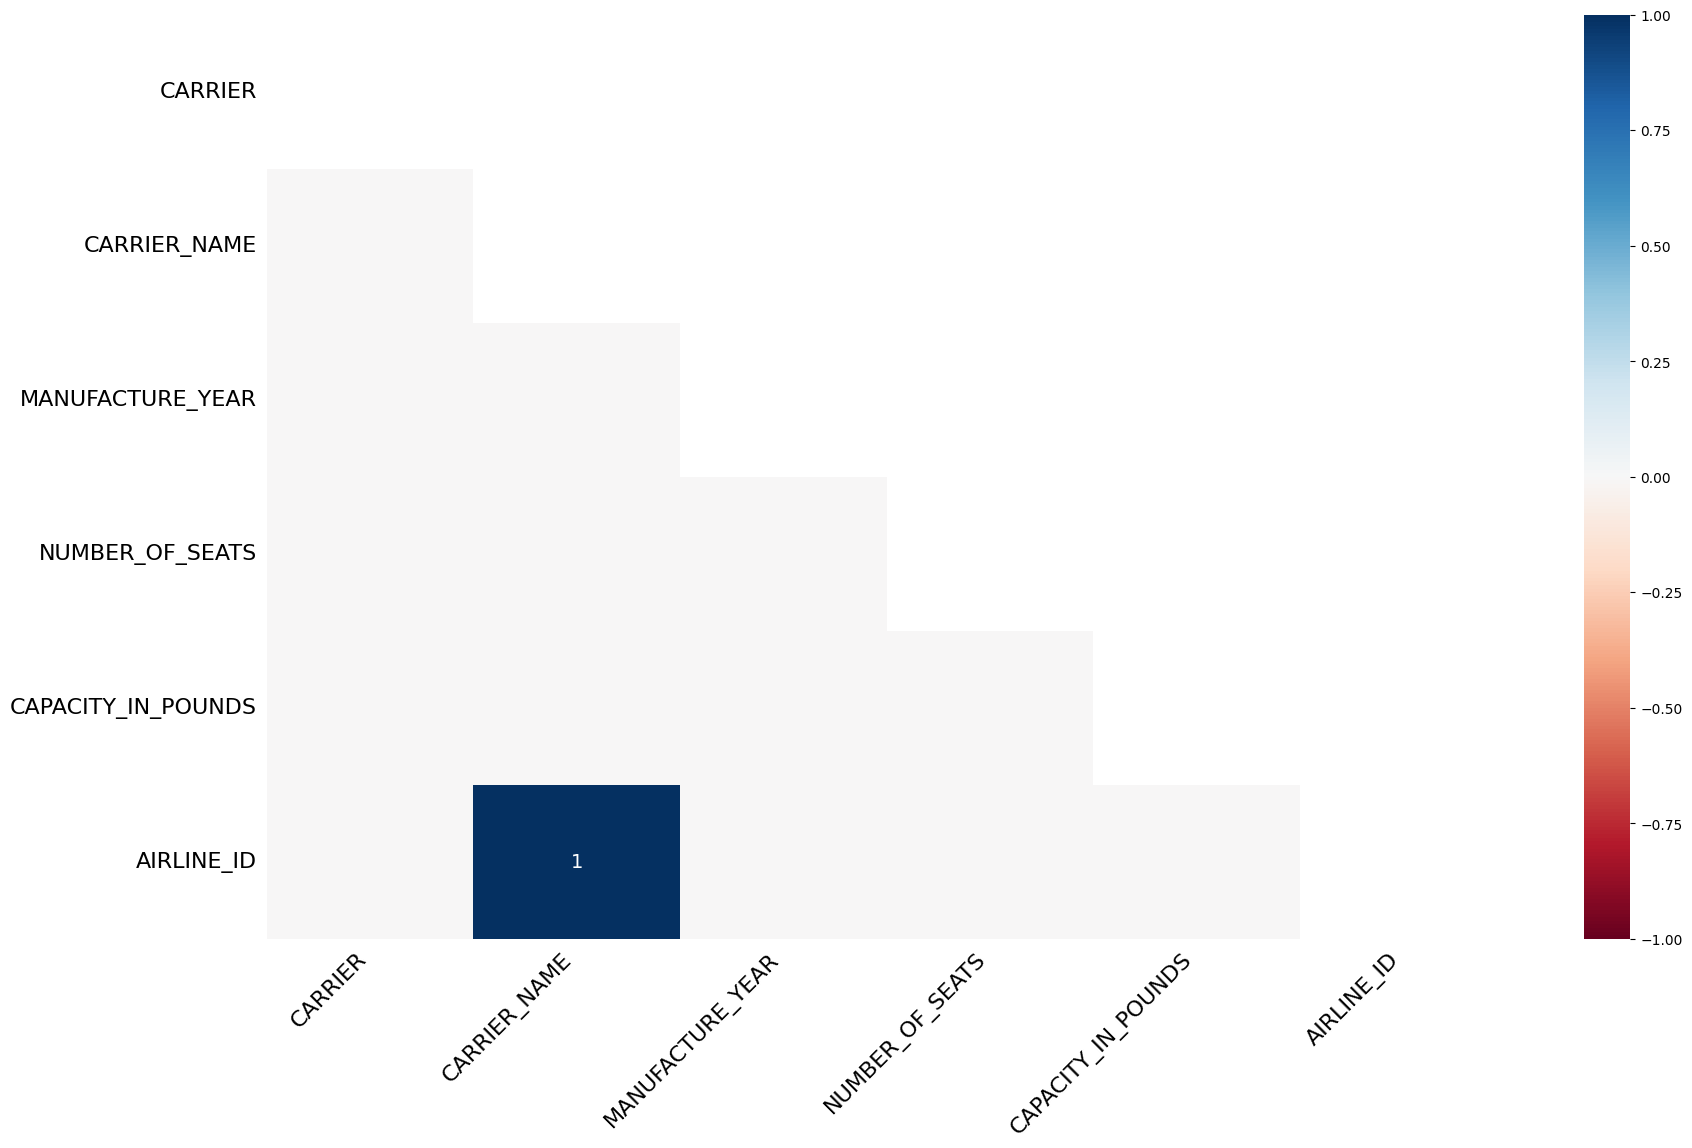

In [223]:
msno.heatmap(inventory[columns_to_check]) 
#airline_id and carrier_name shows a strong correlation

In [224]:
north_american_mask = inventory["CARRIER_NAME"].str.contains("North American", na=False)
missing_carrier_mask = inventory["CARRIER"].isna()
to_fix = north_american_mask & missing_carrier_mask
imputed_inventory.loc[to_fix, "CARRIER"] = "NA"

In [225]:
# carrier_name -> carrier
carrier_pairs = inventory[['CARRIER_NAME', 'CARRIER']].dropna().drop_duplicates()
name_to_carrier_counts = carrier_pairs.groupby('CARRIER_NAME')['CARRIER'].nunique()
unique_names = name_to_carrier_counts[name_to_carrier_counts == 1].index
carrier_map = dict(carrier_pairs[carrier_pairs['CARRIER_NAME'].isin(unique_names)].values)

for idx, row in imputed_inventory[imputed_inventory['CARRIER'].isnull()].iterrows():
    name = row['CARRIER_NAME']
    if name in carrier_map:
        imputed_inventory.at[idx, 'CARRIER'] = carrier_map[name]

# carrier -> carrier_name
carrier_pairs = inventory[['CARRIER', 'CARRIER_NAME']].dropna().drop_duplicates()
carrier_to_name_counts = carrier_pairs.groupby('CARRIER')['CARRIER_NAME'].nunique()
unique_carriers = carrier_to_name_counts[carrier_to_name_counts == 1].index
name_map = dict(carrier_pairs[carrier_pairs['CARRIER'].isin(unique_carriers)].values)

for idx, row in imputed_inventory[imputed_inventory['CARRIER_NAME'].isnull()].iterrows():
    code = row['CARRIER']
    if code in name_map:
        imputed_inventory.at[idx, 'CARRIER_NAME'] = name_map[code]


In [226]:
# unique carrier name -> carrier name
carrier_pairs = inventory[['UNIQUE_CARRIER_NAME', 'CARRIER_NAME']].dropna().drop_duplicates()
carrier_to_name_counts = carrier_pairs.groupby('UNIQUE_CARRIER_NAME')['CARRIER_NAME'].nunique()
unique_carriers = carrier_to_name_counts[carrier_to_name_counts == 1].index
name_map = dict(carrier_pairs[carrier_pairs['UNIQUE_CARRIER_NAME'].isin(unique_carriers)].values)

for idx, row in imputed_inventory[imputed_inventory['CARRIER_NAME'].isnull()].iterrows():
    code = row['UNIQUE_CARRIER_NAME']
    if code in name_map:
        imputed_inventory.at[idx, 'CARRIER_NAME'] = name_map[code]

In [227]:
# now carrier <-> airline_id

carrier_airline_pairs = imputed_inventory[['CARRIER', 'AIRLINE_ID']].dropna().drop_duplicates()

carrier_to_airline_counts = carrier_airline_pairs.groupby('CARRIER')['AIRLINE_ID'].nunique()
unique_carriers = carrier_to_airline_counts[carrier_to_airline_counts == 1].index
carrier_to_airline_map = carrier_airline_pairs[carrier_airline_pairs['CARRIER'].isin(unique_carriers)]
carrier_to_airline_map = dict(zip(carrier_to_airline_map['CARRIER'], carrier_to_airline_map['AIRLINE_ID']))

for idx, row in imputed_inventory[imputed_inventory['AIRLINE_ID'].isna()].iterrows():
    carrier = row['CARRIER']
    if carrier in carrier_to_airline_map:
        imputed_inventory.at[idx, 'AIRLINE_ID'] = carrier_to_airline_map[carrier]

airline_to_carrier_counts = carrier_airline_pairs.groupby('AIRLINE_ID')['CARRIER'].nunique()
unique_airlines = airline_to_carrier_counts[airline_to_carrier_counts == 1].index
airline_to_carrier_map = carrier_airline_pairs[carrier_airline_pairs['AIRLINE_ID'].isin(unique_airlines)]
airline_to_carrier_map = dict(zip(airline_to_carrier_map['AIRLINE_ID'], airline_to_carrier_map['CARRIER']))

for idx, row in imputed_inventory[imputed_inventory['CARRIER'].isna()].iterrows():
    airline_id = row['AIRLINE_ID']
    if airline_id in airline_to_carrier_map:
        imputed_inventory.at[idx, 'CARRIER'] = airline_to_carrier_map[airline_id]


In [228]:
# manufacture year is median for the given model
median_year_by_model = inventory.groupby('MODEL')['MANUFACTURE_YEAR'].transform('median')
imputed_inventory['MANUFACTURE_YEAR'] = imputed_inventory['MANUFACTURE_YEAR'].fillna(median_year_by_model)


In [229]:
# capacity_in_pounds and num seats
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)
imputed_inventory[["CAPACITY_IN_POUNDS", "NUMBER_OF_SEATS"]] = knn_imputer.fit_transform(imputed_inventory[["CAPACITY_IN_POUNDS", "NUMBER_OF_SEATS"]])

In [230]:
summary = []

for col in columns_to_check:
    inventory_na = inventory[col].isna().sum()
    imputed_na = imputed_inventory[col].isna().sum()
    summary.append({
        'Column': col,
        'Missing Before': inventory_na,
        'Missing After': imputed_na,
        'Filled': inventory_na - imputed_na
    })

print(summary)

[{'Column': 'CARRIER', 'Missing Before': 49, 'Missing After': 0, 'Filled': 49}, {'Column': 'CARRIER_NAME', 'Missing Before': 105, 'Missing After': 97, 'Filled': 8}, {'Column': 'MANUFACTURE_YEAR', 'Missing Before': 3, 'Missing After': 0, 'Filled': 3}, {'Column': 'NUMBER_OF_SEATS', 'Missing Before': 7, 'Missing After': 0, 'Filled': 7}, {'Column': 'CAPACITY_IN_POUNDS', 'Missing Before': 101, 'Missing After': 0, 'Filled': 101}, {'Column': 'AIRLINE_ID', 'Missing Before': 105, 'Missing After': 97, 'Filled': 8}]


# Question 2 - Data Cleaning

In [231]:
print("MANUFACTURER Column Value Counts:")
#print(imputed_inventory['MANUFACTURER'].value_counts())
imputed_inventory['MANUFACTURER'] = imputed_inventory['MANUFACTURER'].str.strip().str.upper()
# mix casing - lots of conflicts (eg Boeing)

#don't normalize model

print("\nAIRCRAFT_STATUS Column Value Counts:")
print(imputed_inventory['AIRCRAFT_STATUS'].value_counts())
imputed_inventory['AIRCRAFT_STATUS'] = imputed_inventory['AIRCRAFT_STATUS'].str.strip().str.lower()

print("\nOPERATING_STATUS Column Value Counts:")
print(imputed_inventory['OPERATING_STATUS'].value_counts())
imputed_inventory['OPERATING_STATUS'] = imputed_inventory['OPERATING_STATUS'].str.strip().str.lower()
operating_status_map = {'n': 0, 'y': 1}
imputed_inventory["OPERATING_STATUS"] = imputed_inventory["OPERATING_STATUS"].map(operating_status_map)

print("\nAfter Cleaning:")
print(imputed_inventory[['MANUFACTURER', 'MODEL', 'AIRCRAFT_STATUS', 'OPERATING_STATUS']].head())


MANUFACTURER Column Value Counts:

AIRCRAFT_STATUS Column Value Counts:
AIRCRAFT_STATUS
O    79487
b    30852
B    12699
a     7804
A     1330
L      122
o       19
Name: count, dtype: int64

OPERATING_STATUS Column Value Counts:
OPERATING_STATUS
Y    126577
N      5664
y        71
          1
Name: count, dtype: int64

After Cleaning:
  MANUFACTURER    MODEL AIRCRAFT_STATUS  OPERATING_STATUS
0     CANADAIR  CRJ-2/4               b               1.0
1     CANADAIR  CRJ-2/4               b               1.0
2     CANADAIR  CRJ-2/4               b               1.0
3     CANADAIR  CRJ-2/4               b               1.0
4     CANADAIR  CRJ-2/4               b               1.0


In [232]:
# manufacture name detailed cleaning 

print(imputed_inventory["MANUFACTURER"].value_counts())
#imputed_inventory['MANUFACTURER'].value_counts().head(20)
MANUFACTURER_NAMES = ["BOEING", "AIRBUS", "CANADAIR", "BOMBARDIER", "MCDONNELL DOUGLAS", "EMBRAER" ,"LOCKHEED", "CESSNA", "GULFSTREAM", "LEARJET", "MD HELICOPTERS", "SAAB", "FOKKER"]


MANUFACTURER
BOEING              27159
EMBRAER             15554
AIRBUS              13440
BOMBARDIER          11834
THEBOEINGCO          9231
                    ...  
BEECHHAWKER400XP        1
FOKKER71                1
FOKKER70                1
FOKKER72                1
JSA/PEACH               1
Name: count, Length: 134, dtype: int64


In [233]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd

imputed_inventory['MANUFACTURER'] = imputed_inventory['MANUFACTURER'].fillna('UNKNOWN')

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4))
X = vectorizer.fit_transform(MANUFACTURER_NAMES)
y = vectorizer.transform(imputed_inventory['MANUFACTURER'])

nn = NearestNeighbors(n_neighbors=1, metric='cosine').fit(X)
distances, indices = nn.kneighbors(y)

threshold = 0.3
matches = [MANUFACTURER_NAMES[idx[0]] if dist[0] < threshold else orig 
           for idx, dist, orig in zip(indices, distances, imputed_inventory['MANUFACTURER'])]

imputed_inventory['MANUFACTURER'] = matches


In [234]:
imputed_inventory["MANUFACTURER"].value_counts()

MANUFACTURER
BOEING                        55519
AIRBUS                        23517
EMBRAER                       15554
BOMBARDIER                    12483
MCDONNELL DOUGLAS              9373
                              ...  
ROLLS-ROYCE                       1
MCDONNEL                          1
B757-223                          1
DASSAULT-FALCON-2000EXEASY        1
JSA/PEACH                         1
Name: count, Length: 104, dtype: int64

# Question 3 - Remove missing rows

In [235]:
original_rows = imputed_inventory.shape[0]
imputed_inventory_cleaned = imputed_inventory.dropna()
remaining_rows = imputed_inventory_cleaned.shape[0]

print(f"Num rows: {original_rows}")
print(f"Remaining rows: {remaining_rows}")
print(f"Rows removed:{original_rows - remaining_rows}")

Num rows: 132313
Remaining rows: 101275
Rows removed:31038


In [236]:
# Question 4 - Transformative & Derivative

Skewness - NUMBER_OF_SEATS: 0.38
Skewness - CAPACITY_IN_POUNDS: 3.77


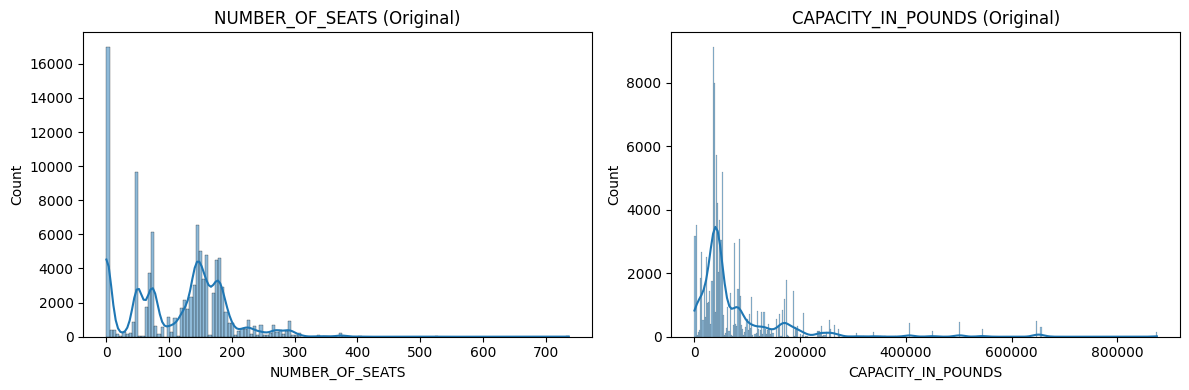

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

seats = imputed_inventory_cleaned["NUMBER_OF_SEATS"]
capacity = imputed_inventory_cleaned["CAPACITY_IN_POUNDS"]

print(f"Skewness - NUMBER_OF_SEATS: {seats.skew():.2f}")
print(f"Skewness - CAPACITY_IN_POUNDS: {capacity.skew():.2f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(seats, kde=True, ax=axes[0]).set_title("NUMBER_OF_SEATS (Original)")
sns.histplot(capacity, kde=True, ax=axes[1]).set_title("CAPACITY_IN_POUNDS (Original)")
plt.tight_layout()
plt.show()


In [238]:
from scipy.stats import boxcox

seats_positive = seats[seats > 0]
capacity_positive = capacity[capacity > 0]

seats_boxcox, _ = boxcox(seats_positive)
capacity_boxcox, _ = boxcox(capacity_positive)

inventory.loc[seats_positive.index, 'NUMBER_OF_SEATS_BOXCOX'] = seats_boxcox
inventory.loc[capacity_positive.index, 'CAPACITY_IN_POUNDS_BOXCOX'] = capacity_boxcox


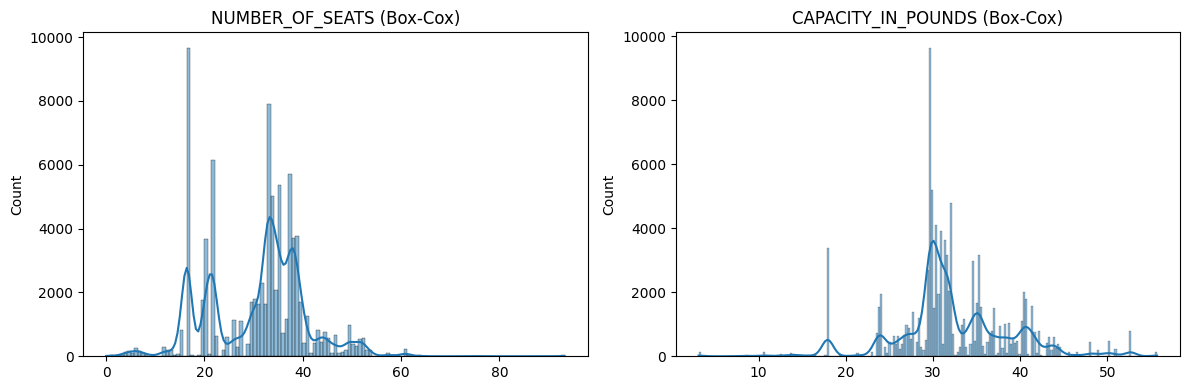

In [239]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(seats_boxcox, kde=True, ax=axes[0]).set_title("NUMBER_OF_SEATS (Box-Cox)")
sns.histplot(capacity_boxcox, kde=True, ax=axes[1]).set_title("CAPACITY_IN_POUNDS (Box-Cox)")
plt.tight_layout()
plt.show()

In [240]:
"""
Before transformation: Both variables showed strong left skewness, especially CAPACITY_IN_POUNDS, indicating the presence of some extremely small values.

After Box-Cox transformation: The distributions became more symmetric and bell-shaped, closer to a normal distribution.
"""

'\nBefore transformation: Both variables showed strong left skewness, especially CAPACITY_IN_POUNDS, indicating the presence of some extremely small values.\n\nAfter Box-Cox transformation: The distributions became more symmetric and bell-shaped, closer to a normal distribution.\n'

# Question 5 - Feature Engineering 

In [241]:
q1 = imputed_inventory_cleaned['NUMBER_OF_SEATS'].quantile(0.25)
q2 = imputed_inventory_cleaned['NUMBER_OF_SEATS'].quantile(0.50)
q3 = imputed_inventory_cleaned['NUMBER_OF_SEATS'].quantile(0.75)

def classify_size(seats):
    if pd.isna(seats):
        return None
    elif seats < q1:
        return 'SMALL'
    elif seats < q2:
        return 'MEDIUM'
    elif seats < q3:
        return 'LARGE'
    else:
        return 'XLARGE'

imputed_inventory_cleaned['SIZE'] = imputed_inventory_cleaned['NUMBER_OF_SEATS'].apply(classify_size)


C:\Users\siddh\AppData\Local\Temp\ipykernel_9264\4093031548.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_inventory_cleaned['SIZE'] = imputed_inventory_cleaned['NUMBER_OF_SEATS'].apply(classify_size)


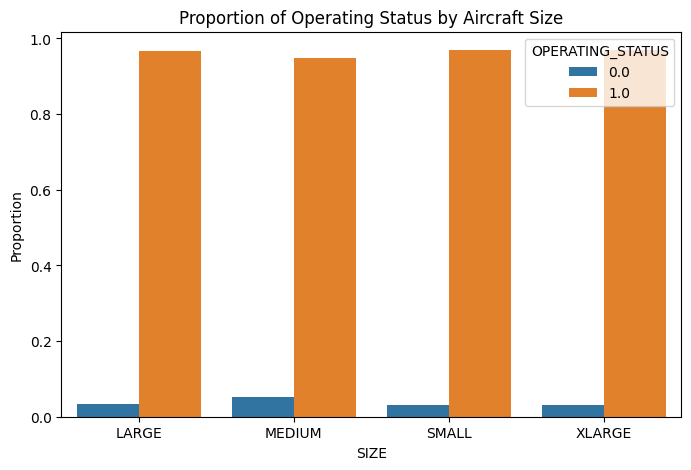

In [242]:
import seaborn as sns
import matplotlib.pyplot as plt

op_status_counts = (
    imputed_inventory_cleaned.groupby('SIZE')['OPERATING_STATUS']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.barplot(data=op_status_counts, x='SIZE', y='proportion', hue='OPERATING_STATUS')
plt.title('Proportion of Operating Status by Aircraft Size')
plt.ylabel('Proportion')
plt.show()


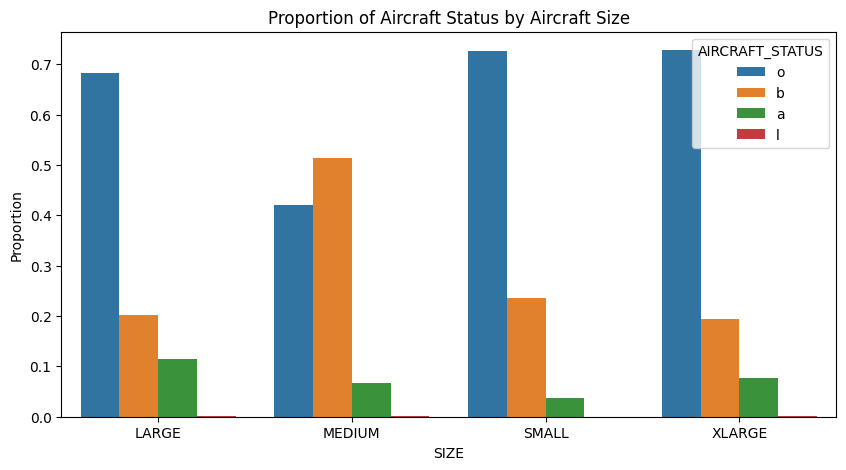

In [243]:
aircraft_status_counts = (
    imputed_inventory_cleaned.groupby('SIZE')['AIRCRAFT_STATUS']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=aircraft_status_counts, x='SIZE', y='proportion', hue='AIRCRAFT_STATUS')
plt.title('Proportion of Aircraft Status by Aircraft Size')
plt.ylabel('Proportion')
plt.show()
